In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import numpy as np

from fmriprep_denoise.visualization import figures
from fmriprep_denoise.features import partial_correlation, fdr, calculate_median_absolute, get_atlas_pairwise_distance

import matplotlib.pyplot as plt
import seaborn as sns

from myst_nb import glue

grid_location = {
    (0, 0): 'baseline',
    (0, 2): 'simple',
    (0, 3): 'simple+gsr',
    (1, 0): 'scrubbing.5',
    (1, 1): 'scrubbing.5+gsr',
    (1, 2): 'scrubbing.2',
    (1, 3): 'scrubbing.2+gsr',
    (2, 0): 'compcor',
    (2, 1): 'compcor6',
    (2, 2): 'aroma',
    (2, 3): 'aroma+gsr',
}


# Load metric data
path_root = Path.cwd().parents[0] / "inputs"
dataset = "ds000228"
atlas_name = "schaefer7networks"
dimension = 400
(qcfc_per_edge, sig_per_edge, modularity, movement, pairwise_distance) = figures.load_metrics(dataset, atlas_name, dimension, path_root)

long_qcfc = qcfc_per_edge.melt()
long_qcfc.columns = ["Strategy", "qcfc"]

corr_distance_long = qcfc_per_edge.melt()
corr_distance_long.columns = ["Strategy", "qcfc"]
corr_distance_long['distance'] = np.tile(pairwise_distance.iloc[:, -1].values, 11)

modularity_order = modularity.mean().sort_values().index.tolist()


qcfc_sig = figures._qcfc_fdr(sig_per_edge)
qcfc_mad = figures._get_qcfc_median_absolute(qcfc_per_edge)
qcfc_dist = figures._get_corr_distance(pairwise_distance, qcfc_per_edge)
corr_mod = figures._corr_modularity_motion(modularity, movement)
network_mod = {
    'data': modularity,
    'order': modularity_order,
    'title': "Identifiability of network structure\nafter denoising",
    'label': "Mean modularity quality (a.u.)",
}

# OHBM 2022 abstract

## Impact of confound removal strategies on functional connectivity generated from fMRIPrep outputs

H-T Wang[^1], S L Meisler[^2][^3], H Shamarke, F Paugam[^1][^4], N Gensollen[^5], B Thirion[^5], C Markiewicz[^6], P Bellec[^1][^7]

[^1]: Centre de recherche de l'institut Universitaire de gériatrie de Montréal (CRIUGM), Montréal, Québec, Canada

[^2]: Harvard University, MA, USA

[^3]: Massachusetts Institute of Technology, MA, USA

[^4]: Computer Science and Operations Research Department, Université de Montréal, Montréal, Québec, Canada

[^5]: Inria, CEA, Université Paris-Saclay, Paris, France

[^6]: Department of Psychology, Stanford University, Stanford, United States

[^7]: Psychology Department, Université de Montréal, Montréal, Québec, Canada

### Introduction

Selecting an optimal denoising strategy is a key issue when processing fMRI data. 
The popular software fMRIPrep {cite:p}`esteban_fmriprep_2020` aims to standardize fMRI preprocessing, 
but users are still offered a wide range of confound regressors to choose from to denoise data. 
Without a good understanding of the literature or the fMRIPrep documentation, 
users can select suboptimal strategies. 
Current work aims to provide a useful reference for fMRIPrep users by systematically evaluating the impact of different confound regression strategies, 
and by contrasting the results with past literature based on alternative preprocessing software.    

### Methods

We selected dataset ds000228 {cite:p}`richardson_development_2018` on OpenNeuro, which we preprocessed with fMRIPrep LTS20.2.1 using option `--use-aroma`. 
Time series were extracted using the Schaefer 7 network atlas with 400 ROIs {cite:p}`schaefer_local-global_2017`. 
We applied the denoising strategies listed in the table below using fMRIPrep-generated confounds. 
Subjects with less than 80% of remaining volumes after scrubbing with a 0.5 mm threshold were excluded from all analysis. 
We also calculated the connectome from high-pass filtered time series as a comparison baseline.


| strategy      | image                          | `high_pass` | `motion` | `wm_csf` | `global_signal` | `scrub` | `fd_thresh` | `compcor`     | `n_compcor` | `ica_aroma` | `demean` |
|---------------|--------------------------------|-------------|----------|----------|-----------------|---------|-------------|---------------|-------------|-------------|----------|
| baseline      | `desc-preproc_bold`            | `True`      | N/A      | N/A      | N/A             | N/A     | N/A         | N/A           | N/A         | N/A         | `True`   |
| simple        | `desc-preproc_bold`            | `True`      | full     | basic    | N/A             | N/A     | N/A         | N/A           | N/A         | N/A         | `True`   |
| simple+gsr    | `desc-preproc_bold`            | `True`      | full     | basic    | basic           | N/A     | N/A         | N/A           | N/A         | N/A         | `True`   |
| scrubbing     | `desc-preproc_bold`            | `True`      | full     | full     | N/A             | 5       | 0.5         | N/A           | N/A         | N/A         | `True`   |
| scrubbing+gsr | `desc-preproc_bold`            | `True`      | full     | full     | basic           | 5       | 0.5         | N/A           | N/A         | N/A         | `True`   |
| compcor       | `desc-preproc_bold`            | `True`      | full     | N/A      | N/A             | N/A     | N/A         | anat_combined | all         | N/A         | `True`   |
| compcor6      | `desc-preproc_bold`            | `True`      | full     | N/A      | N/A             | N/A     | N/A         | anat_combined | 6           | N/A         | `True`   |
| aroma         | `desc-smoothAROMAnonaggr_bold` | `True`      | N/A      | basic    | N/A             | N/A     | N/A         | N/A           | N/A         | full        | `True`   |
| aroma+gsr     | `desc-smoothAROMAnonaggr_bold` | `True`      | N/A      | basic    | basic           | N/A     | N/A         | N/A           | N/A         | full        | `True`   |

We used three metrics {cite:p}`ciric_benchmarking_2017`, {cite:p}`parkes_evaluation_2018` to evaluate the denoising results:
1. Quality control / functional connectivity (QCFC {cite:p}`power_recent_2015`): partial correlation between motion and connectivity with age and sex as covariates. We control for multiple comparisons with false positive rate correction.
2. Distance-dependent effects of motion on connectivity {cite:p}`power_scrubbing_2012`: correlation between node-wise Euclidean distance and QC-FC.
3. Network modularity {cite:p}`satterthwaite_impact_2012`: graph community detection based on Louvain method, implemented in the Brain Connectome Toolbox.

### Results

#### QC-FC and distance-dependent effect

No denoise strategy removed the correlation with motion captured by mean framewise displacement. 
`aroma`, `compcor6`, and `simple` reduced the correlation between connectivity edges and mean framewise displacement. 
`scrubbing` and `scrubbing+gsr` performed the best, as seen in previous work {cite:p}`power_recent_2015`. 
`compcor`, which applies compcor-based regressors covering 50% of the variance, performs worse than the connectome baseline created with high-pass filtered time series. 
Surprisingly, all strategies with global signal regression underperform, contradicting the existing literature {cite:p}`ciric_benchmarking_2017` {cite:p}`parkes_evaluation_2018`.

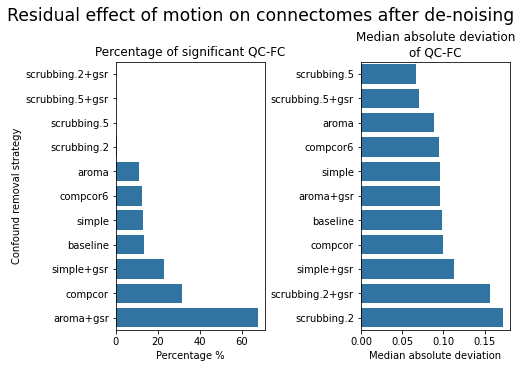

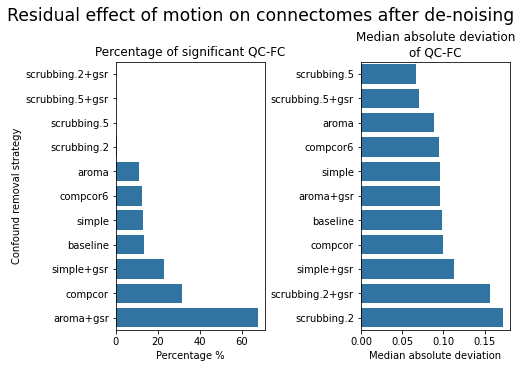

In [2]:
bar_color = sns.color_palette()[0]

fig = plt.figure(constrained_layout=True, figsize=(7, 5))
fig.suptitle('Residual effect of motion on connectomes after de-noising', fontsize='xx-large')
axs = fig.subplots(1, 2, sharey=False)
for nn, (ax, figure_data) in enumerate(zip(axs, [qcfc_sig, qcfc_mad])):
    sns.barplot(data=figure_data['data'], orient='h',
                ci=None, order=figure_data['order'],
                color=bar_color, ax=ax)
    ax.set_title(figure_data['title'])
    ax.set(xlabel=figure_data['label'])
    if nn == 0:
        ax.set(ylabel="Confound removal strategy")
glue("qcfc-fig", fig, display=False)

```{glue:figure} qcfc-fig
:figwidth: 800px
:name: "qcfc-fig"
```

#### Distance-dependent effects of motion on connectivity

Consistent with the literature, `aroma` reduces the distance dependency of motion on connectivity.

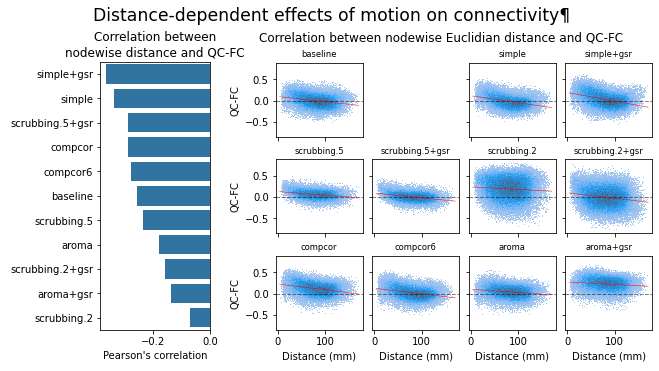

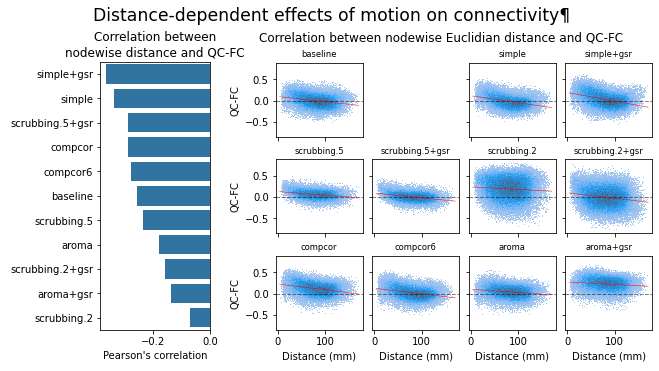

In [3]:
fig = plt.figure(constrained_layout=True, figsize=(9, 5))
subfigs = fig.subfigures(1, 2, width_ratios=[1, 2])
fig.suptitle('Residual effect of motion on connectomes after de-noising', fontsize='x-large')

ax = subfigs[0].subplots(1, 1, sharex=True, sharey=True)

sns.barplot(data=qcfc_dist['data'], orient='h',
            ci=None, order=qcfc_dist['order'],
            color=bar_color, ax=ax)
ax.set_title(qcfc_dist['title'])
ax.set(xlabel=qcfc_dist['label'])
if nn == 0:
    ax.set(ylabel="Confound removal strategy")

axs = subfigs[1].subplots(3, 4, sharex=True, sharey=True)
for i, row_axes in enumerate(axs):
    for j, ax in enumerate(row_axes):
        if cur_strategy := grid_location.get((i, j), False):
            mask = corr_distance_long["Strategy"] == cur_strategy
            g = sns.histplot(data=corr_distance_long.loc[mask, :],
                                x='distance', y='qcfc',
                                ax=ax)
            ax.set_title(cur_strategy, fontsize='small')
            g.axhline(0, linewidth=1, linestyle='--', alpha=0.5, color='k')
            sns.regplot(data=corr_distance_long.loc[mask, :],
                        x='distance', y='qcfc',
                        ci=None,
                        scatter=False,
                        line_kws={'color': 'r', 'linewidth': 0.5},
                        ax=ax)
            xlabel = "Distance (mm)" if i == 2 else None
            ylabel = "QC-FC" if j == 0 else None
            g.set(xlabel=xlabel, ylabel=ylabel)
        else:
            subfigs[1].delaxes(axs[i, j])
subfigs[1].suptitle('Correlation between nodewise Euclidian distance and QC-FC')
fig.suptitle('Distance-dependent effects of motion on connectivity¶', fontsize='xx-large')
glue("dist-fig", fig, display=False)

```{glue:figure} dist-fig
:figwidth: 800px
:name: "dist-fig"
```

#### Network modularity

All strategies increased the overall network modularity compared to the `baseline`, with scrubbing based methods performing the best out of all. 
GSR-based strategies improved the network modularity compared to their conunterparts.
The correlation between modularity quality and motion for each denoising approach shows that compcor-based and ICA-AROMA strategies are the best at eliminating correlations between motion and modularity.

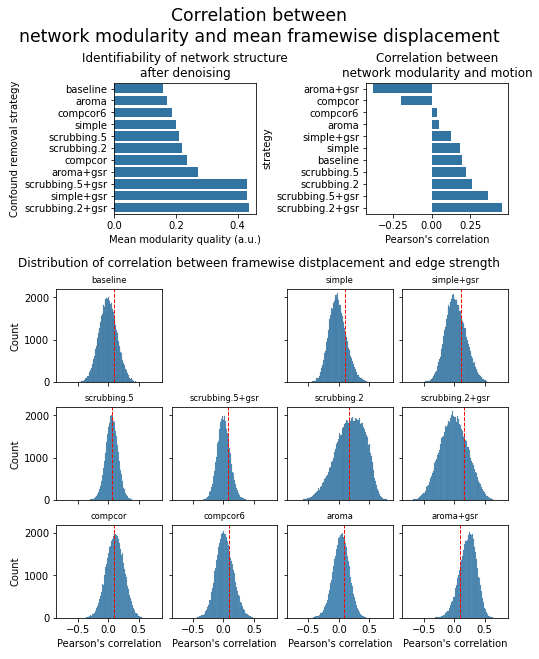

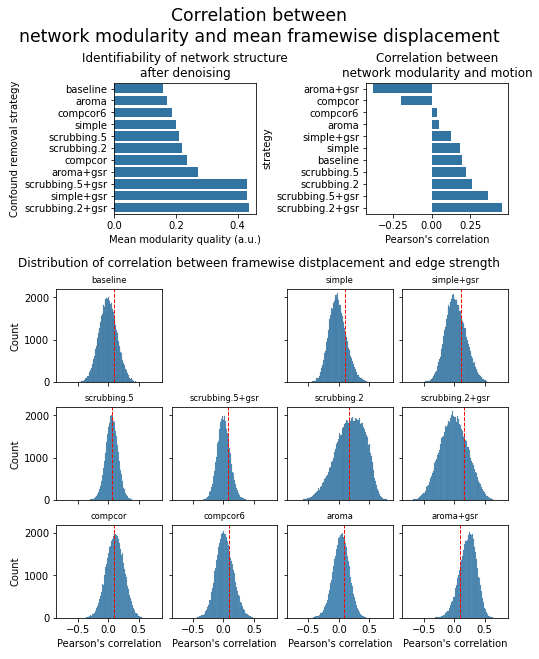

In [4]:
fig = plt.figure(constrained_layout=True, figsize=(7, 9))
subfigs = fig.subfigures(2, 1, height_ratios=[1, 2])
axsTopRight = subfigs[0].subplots(1, 2, sharey=False)
sns.barplot(data=network_mod['data'],
            orient='h',
            ci=None,
            order=network_mod['order'],
            color=bar_color, ax=axsTopRight[0])
axsTopRight[0].set_title(network_mod['title'])
axsTopRight[0].set(xlabel=network_mod['label'])
axsTopRight[0].set(ylabel="Confound removal strategy")

sns.barplot(data=corr_mod['data'], x='correlation', y='strategy',
            ci=None,
            order=None,
            color=bar_color, ax=axsTopRight[1])
axsTopRight[1].set_title(corr_mod['title'])
axsTopRight[1].set(xlabel=corr_mod['label'])

fig.suptitle('Correlation between\nnetwork modularity and mean framewise displacement', fontsize='xx-large')

axsBottomRight = subfigs[1].subplots(3, 4, sharex=True, sharey=True)
for i, row_axes in enumerate(axsBottomRight):
    for j, ax in enumerate(row_axes):
        if cur_strategy := grid_location.get((i, j), False):
            mask = long_qcfc["Strategy"] == cur_strategy
            g = sns.histplot(data=long_qcfc.loc[mask, :],
                            x='qcfc',
                            ax=ax)
            g.set_title(cur_strategy, fontsize='small')
            mad = qcfc_mad['data'][cur_strategy].values
            g.axvline(mad, linewidth=1, linestyle='--', color='r')
            xlabel = "Pearson\'s correlation" if i == 2 else None
            g.set(xlabel=xlabel)
        else:
            subfigs[1].delaxes(axsBottomRight[i, j])
subfigs[1].suptitle('Distribution of correlation between framewise distplacement and edge strength')


glue("network-fig", fig, display=False)

```{glue:figure} network-fig
:figwidth: 800px
:name: "network-fig"
```


### Conclusions


We replicated previous findings demonstrating the usefulness of standard denoising strategies (compcor, aroma, etc.).
However, results involving global signal regression methods systematically contradict the literature{cite:p}`ciric_benchmarking_2017` {cite:p}`parkes_evaluation_2018`. 
This evaluation is implemented in a fully reproducible jupyter book framework, and it can be applied to evaluate denoising strategies for future fMRIPrep release. 
This software may also be useful for researchers to select the most suitable strategy and produce denoising benchmarks for their own dataset.                 


### References
```{bibliography}
:filter: docname in docnames
```